In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
path = Path("../../Datasets/Chicago Transit Authority Passenger Data/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path,parse_dates=["service_date"])
df.columns = ["date", "day_type","bus", "rail", "total"]

In [3]:
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


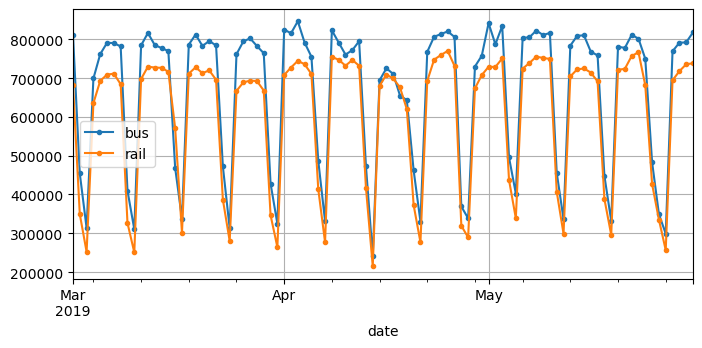

In [5]:
df["2019-03":"2019-05"].plot(grid=True,marker=".", figsize=(8,3.5))
plt.show()

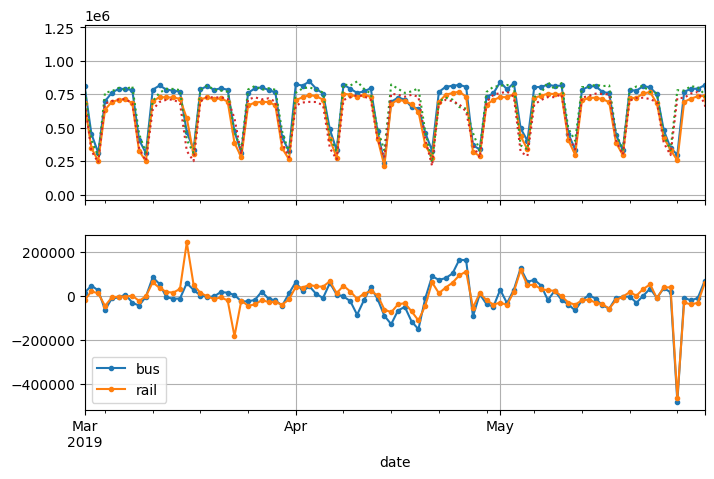

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]
fig, axs = plt.subplots(2,1,sharex=True,figsize=(8,5))
df.plot(ax=axs[0],legend=False,marker=".")
df.shift(7).plot(ax=axs[0],grid=True,legend=False,linestyle=":")
diff_7.plot(ax=axs[1],grid=True,marker=".")
plt.show()

In [7]:
list(df.loc['2019-05-25':'2019-05-27']['day_type'])

['A', 'U', 'U']

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

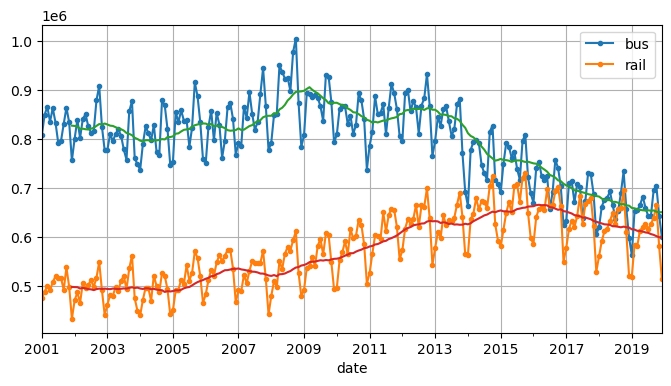

In [10]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

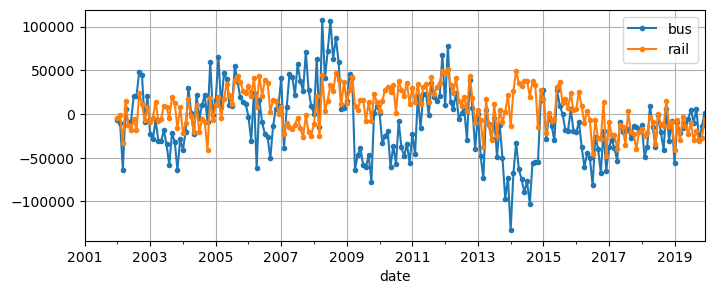

In [11]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(8,3))
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1,0,0), seasonal_order=(0,1,1,7))

model = model.fit()
y_pred = model.forecast()

In [13]:
y_pred

2019-06-01    427758.626342
Freq: D, dtype: float64

In [14]:
origin,start_date,end_date = "2019-01-01","2019-03-01","2019-05-31"

time_period = pd.date_range(start_date,end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")

y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],
                  order=(1,0,0),
                  seasonal_order=(0,1,1,7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds,index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [15]:
mae

32040.720101159208

In [16]:
import tensorflow as tf
my_series = [0, 1, 2, 3, 4, 5]

my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets = my_series[3:],
    sequence_length=3,
    batch_size=2
)

In [17]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [18]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}",end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [19]:
dataset = tf.data.Dataset.range(6).window(4, shift = 1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset:window_dataset.batch(4))
for window_dataset in dataset:
    print(f"{window_dataset}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [20]:
def to_windows(dataset,length):
    dataset = dataset.window(length,shift=1,drop_remainder=True)
    return dataset.flat_map(lambda window_ds:window_ds.batch(length))

In [21]:
dataset = to_windows(tf.data.Dataset.range(6),4)
dataset = dataset.map(lambda window: (window[:1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 1), dtype=int64, numpy=
  array([[0],
         [1]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

In [22]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [23]:
rail_train

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
                ...   
2018-12-27    0.453029
2018-12-28    0.493961
2018-12-29    0.307105
2018-12-30    0.265310
2018-12-31    0.386058
Name: rail, Length: 1096, dtype: float64

In [24]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [25]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])


Epoch 1/500
33/33 [==============================] - 1s 7ms/step - loss: 0.0187 - mae: 0.1599 - val_loss: 0.0131 - val_mae: 0.1136
Epoch 2/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.1145 - val_loss: 0.0129 - val_mae: 0.1119
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.1142 - val_loss: 0.0125 - val_mae: 0.1107
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.1141 - val_loss: 0.0123 - val_mae: 0.1101
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.1138 - val_loss: 0.0121 - val_mae: 0.1096
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0116 - mae: 0.1135 - val_loss: 0.0119 - val_mae: 0.1090
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0115 - mae: 0.1132 - val_loss: 0.0118 - val_mae: 0.1085
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0113 - m

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 6ms/step - loss: 0.0268 - mae: 0.1740 - val_loss: 0.0072 - val_mae: 0.0992
Epoch 2/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0916 - val_loss: 0.0048 - val_mae: 0.0873
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0052 - mae: 0.0773 - val_loss: 0.0031 - val_mae: 0.0623
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0657 - val_loss: 0.0026 - val_mae: 0.0523
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0619 - val_loss: 0.0023 - val_mae: 0.0469
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0037 - mae: 0.0581 - val_loss: 0.0023 - val_mae: 0.0450
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0036 - mae: 0.0570 - val_loss: 0.0023 - val_mae: 0.0450
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0034 - m

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 2s 14ms/step - loss: 0.0305 - mae: 0.1945 - val_loss: 0.0155 - val_mae: 0.1105
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0139 - mae: 0.1389 - val_loss: 0.0132 - val_mae: 0.1380
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0078 - mae: 0.0950 - val_loss: 0.0021 - val_mae: 0.0416
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0051 - mae: 0.0681 - val_loss: 0.0021 - val_mae: 0.0409
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0050 - mae: 0.0665 - val_loss: 0.0037 - val_mae: 0.0642
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0045 - mae: 0.0622 - val_loss: 0.0023 - val_mae: 0.0433
Epoch 7/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0044 - mae: 0.0634 - val_loss: 0.0076 - val_mae: 0.1088
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0048 - 

In [28]:
df_mulvar = df[["bus", "rail"]]/ 1e6
df_mulvar["next_day_type"] = df[["day_type"]].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)

In [29]:
df_mulvar

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0
...,...,...,...,...,...
2022-10-27,0.528826,0.395129,0,0,1
2022-10-28,0.501985,0.352842,1,0,0
2022-10-29,0.311437,0.254149,0,1,0


In [30]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06"]

c:\Users\monda\anaconda3\envs\Deeplearning_CPU\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
mulvar_train

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2016-01-01,0.303321,0.319835,1,0,0
2016-01-02,0.448859,0.365509,0,1,0
2016-01-03,0.340540,0.287661,0,0,1
2016-01-04,0.829429,0.703185,0,0,1
2016-01-05,0.846789,0.727716,0,0,1
...,...,...,...,...,...
2018-12-27,0.509948,0.453029,0,0,1
2018-12-28,0.577497,0.493961,1,0,0
2018-12-29,0.394088,0.307105,0,1,0


In [32]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets = mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32    
)

In [33]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = mulvar_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 7ms/step - loss: 0.0321 - mae: 0.1802 - val_loss: 0.0034 - val_mae: 0.0612
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0601 - val_loss: 0.0025 - val_mae: 0.0518
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0023 - mae: 0.0469 - val_loss: 0.0022 - val_mae: 0.0481
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0021 - mae: 0.0458 - val_loss: 0.0024 - val_mae: 0.0488
Epoch 5/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0021 - mae: 0.0451 - val_loss: 0.0019 - val_mae: 0.0426
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0020 - mae: 0.0435 - val_loss: 0.0018 - val_mae: 0.0417
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0019 - mae: 0.0422 - val_loss: 0.0018 - val_mae: 0.0410
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0018 - m

In [34]:
# X = mulvar_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

# for step_ahead in range(14):
#     y_pred_one = mulvar_model.predict(X)
#     X = np.concatenate([X,y_pred_one.reshape(1, 1, 1)], axis=1)
    

In [35]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets= None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(ahead_train_ds, validation_data=ahead_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 6ms/step - loss: 0.1254 - mae: 0.3758 - val_loss: 0.0331 - val_mae: 0.2031
Epoch 2/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0213 - mae: 0.1667 - val_loss: 0.0153 - val_mae: 0.1365
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0144 - mae: 0.1353 - val_loss: 0.0116 - val_mae: 0.1174
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.1232 - val_loss: 0.0097 - val_mae: 0.1065
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0108 - mae: 0.1144 - val_loss: 0.0087 - val_mae: 0.0992
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0099 - mae: 0.1079 - val_loss: 0.0077 - val_mae: 0.0934
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0092 - mae: 0.1030 - val_loss: 0.0071 - val_mae: 0.0884
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0087 - m

In [37]:
def to_seq2seq_dataset(series, seq_length=56,ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    ds= to_windows(tf.data.Dataset.from_tensor_slices(series), ahead+1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:,0],S[:, 1:,1]))
    if shuffle:
        ds = ds.shuffle(8*batch_size, seed=seed)
    return ds.batch(batch_size)

In [38]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True,input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(seq2seq_train, validation_data=seq2seq_valid, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 8ms/step - loss: 0.1077 - mae: 0.3523 - val_loss: 0.0338 - val_mae: 0.2011
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0216 - mae: 0.1618 - val_loss: 0.0184 - val_mae: 0.1505
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0154 - mae: 0.1376 - val_loss: 0.0147 - val_mae: 0.1314
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0128 - mae: 0.1237 - val_loss: 0.0126 - val_mae: 0.1203
Epoch 5/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0113 - mae: 0.1140 - val_loss: 0.0113 - val_mae: 0.1119
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0102 - mae: 0.1066 - val_loss: 0.0103 - val_mae: 0.1058
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0094 - mae: 0.1009 - val_loss: 0.0095 - val_mae: 0.1009
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0088 - m